# AI-Driven Validator Selection for Secure Proof-of-Stake Blockchain Networks
This notebook demonstrates a modular implementation of a Multi-Agent Reinforcement Learning (MARL) and Explainable AI (XAI) framework for secure validator selection in PoS blockchain networks, as described in the accompanying research paper.

## Notebook Structure
This notebook is organized as follows:

1. **Configuration**: Set up all parameters and paths.
2. **Data Loading & Preprocessing**: Load and align validator data.
3. **Environment Simulation**: Simulate PoS network and validator behaviors.
4. **Agent Definition**: Define base and MARL agents.
5. **Training Loop**: Run MARL training for validator selection.
6. **Evaluation & XAI**: Select top validators, detect malicious agents, and explain decisions.
7. **Export & Visualization**: Save results and visualize trust scores.

In [22]:
# --- Configuration and Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from collections import defaultdict
import csv
import pickle
import logging
import random
import torch
import torch.nn as nn
import torch.optim as optim

# XAI imports
import shap
import lime.lime_tabular

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

@dataclass
class Config:
    dataset_path: str = r"./data/ethereum/validators_mvp.csv"
    log_dir: str = "./logs"
    checkpoint_dir: str = "./checkpoints"
    num_validators: int = 200
    num_epochs: int = 10
    action_space: int = 4  # 0=propose, 1=attest, 2=abstain, 3=adjust-communication
    learning_rate: float = 0.001
    gamma: float = 0.99
    epsilon_start: float = 1.0
    epsilon_decay: float = 0.97
    epsilon_min: float = 0.05
    initial_trust: float = 0.5
    trust_decay: float = 0.01
    trust_reward_weight: float = 0.7
    trust_penalty_weight: float = 0.3
    trust_max: float = 1.0
    trust_min: float = 0.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# --- Data Loading & Preprocessing ---

REQUIRED_COLUMNS = [
    "validator_index", "slashed", "effective_balance_gwei",
    "attestations_total", "att_missed_total",
    "proposals_total", "prop_missed_total",
    "proposal_quality", "peer_feedback", "epoch_consistency", "threat_response"
 ]

DERIVED_COLUMNS = ["stake", "uptime", "missed_att", "missed_prop", "trust_features"]

def normalize_slashed(val):
    if pd.isna(val): return False
    if isinstance(val, (int, float)): return val != 0
    if isinstance(val, str):
        sval = val.strip().lower()
        if sval in {"true", "1", "yes", "y"}: return True
        if sval in {"false", "0", "no", "n", ""}: return False
        try: return float(sval) != 0
        except Exception: return False
    return bool(val)

def load_and_align_dataset(dataset_path):
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")
    df = pd.read_csv(dataset_path) if dataset_path.endswith('.csv') else pd.read_json(dataset_path)
    # Ensure required columns
    for col in REQUIRED_COLUMNS:
        if col not in df.columns:
            df[col] = np.nan
    # Sanitize numeric columns
    for col in ["validator_index","effective_balance_gwei","attestations_total","att_missed_total","proposals_total","prop_missed_total","proposal_quality","peer_feedback","epoch_consistency","threat_response"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    # Fill NaNs and normalize slashed
    df["slashed"] = df.get("slashed", pd.NA).map(normalize_slashed).fillna(False).astype(bool)
    df = df.dropna(subset=["validator_index"])
    df["validator_index"] = df["validator_index"].astype(int)
    df["attestations_total"] = df["attestations_total"].fillna(0)
    df["att_missed_total"] = df["att_missed_total"].fillna(0)
    df["proposals_total"] = df["proposals_total"].fillna(0)
    df["prop_missed_total"] = df["prop_missed_total"].fillna(0)
    df["effective_balance_gwei"] = df["effective_balance_gwei"].fillna(0)
    df["proposal_quality"] = df["proposal_quality"].fillna(0.5)
    df["peer_feedback"] = df["peer_feedback"].fillna(0.5)
    df["epoch_consistency"] = df["epoch_consistency"].fillna(0.5)
    df["threat_response"] = df["threat_response"].fillna(0.5)
    # Feature engineering
    CAP_GWEI = 32_000_000_000
    eff = df["effective_balance_gwei"].clip(lower=0, upper=CAP_GWEI)
    df["stake"] = (eff / float(CAP_GWEI)).fillna(0.0).clip(0, 1)
    df["uptime"] = 1.0 - (df["att_missed_total"] / (df["attestations_total"] + 1e-6)).clip(0, 1)
    df["missed_att"] = df["att_missed_total"]
    df["missed_prop"] = df["prop_missed_total"]
    # Trust features vector for XAI
    df["trust_features"] = df[["stake","uptime","proposal_quality","peer_feedback","epoch_consistency","threat_response"]].values.tolist()
    return df

config = Config()
df = load_and_align_dataset(config.dataset_path)
df.head()

,validator_index,pubkey,status,effective_balance_gwei,slashed,activation_epoch,exit_epoch,withdrawal_credentials,attestations_total,att_missed_total,...,trust_v0,proposal_quality,peer_feedback,epoch_consistency,threat_response,stake,uptime,missed_att,missed_prop,trust_features
0,12345,0x80773a007f9e496a196b8f28fae04ddaa72fa65c0f8a...,active_online,32000000000,False,0,9223372036854775807,0x010000000000000000000000ddc6ed6e6a9c1e55c87b...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,1.0,1.0,0.0,0.0,"[1.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
1,67890,0x85c12b9cd79c0fd7712db78245d14583c465e7c4cf40...,exited,0,False,11751,195058,0x010000000000000000000000210b3cb99fa1de0a6408...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,0.0,1.0,0.0,0.0,"[0.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
2,424242,0xa9bde35da905118cd4347038dca5b8f640ce0d008e88...,exited,0,False,145504,382848,0x010000000000000000000000cd6af2ac2fcc1c8a750f...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,0.0,1.0,0.0,0.0,"[0.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
3,40000,0xa8cff0debed9d49cb48de3a36feafe41897ab596a117...,active_online,32000000000,False,4779,9223372036854775807,0x0078b2fc4b3753a660a8adda1dfc89856bf839e94f44...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,1.0,1.0,0.0,0.0,"[1.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
4,40001,0xa740cfc14cd1ef504e9e86d6effc7dae856b347e6441...,active_online,32000000000,False,4779,9223372036854775807,0x0097c69f5c1d6bcc1f40c581d74c6721a32a9eeba60d...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,1.0,1.0,0.0,0.0,"[1.0, 1.0, 0.5, 0.5, 0.5, 0.5]"


Shape of dataset: (4002, 24)
Columns: ['validator_index', 'pubkey', 'status', 'effective_balance_gwei', 'slashed', 'activation_epoch', 'exit_epoch', 'withdrawal_credentials', 'attestations_total', 'att_missed_total', 'proposals_total', 'prop_missed_total', 'inclusion_delay_avg', 'rewards_sum_gwei', 'trust_v0', 'proposal_quality', 'peer_feedback', 'epoch_consistency', 'threat_response', 'stake', 'uptime', 'missed_att', 'missed_prop', 'trust_features']


,validator_index,pubkey,status,effective_balance_gwei,slashed,activation_epoch,exit_epoch,withdrawal_credentials,attestations_total,att_missed_total,...,trust_v0,proposal_quality,peer_feedback,epoch_consistency,threat_response,stake,uptime,missed_att,missed_prop,trust_features
0,12345,0x80773a007f9e496a196b8f28fae04ddaa72fa65c0f8a...,active_online,32000000000,False,0,9223372036854775807,0x010000000000000000000000ddc6ed6e6a9c1e55c87b...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,1.0,1.0,0.0,0.0,"[1.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
1,67890,0x85c12b9cd79c0fd7712db78245d14583c465e7c4cf40...,exited,0,False,11751,195058,0x010000000000000000000000210b3cb99fa1de0a6408...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,0.0,1.0,0.0,0.0,"[0.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
2,424242,0xa9bde35da905118cd4347038dca5b8f640ce0d008e88...,exited,0,False,145504,382848,0x010000000000000000000000cd6af2ac2fcc1c8a750f...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,0.0,1.0,0.0,0.0,"[0.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
3,40000,0xa8cff0debed9d49cb48de3a36feafe41897ab596a117...,active_online,32000000000,False,4779,9223372036854775807,0x0078b2fc4b3753a660a8adda1dfc89856bf839e94f44...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,1.0,1.0,0.0,0.0,"[1.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
4,40001,0xa740cfc14cd1ef504e9e86d6effc7dae856b347e6441...,active_online,32000000000,False,4779,9223372036854775807,0x0097c69f5c1d6bcc1f40c581d74c6721a32a9eeba60d...,0.0,0.0,...,0.0,0.5,0.5,0.5,0.5,1.0,1.0,0.0,0.0,"[1.0, 1.0, 0.5, 0.5, 0.5, 0.5]"



Summary statistics:


,validator_index,pubkey,status,effective_balance_gwei,slashed,activation_epoch,exit_epoch,withdrawal_credentials,attestations_total,att_missed_total,...,trust_v0,proposal_quality,peer_feedback,epoch_consistency,threat_response,stake,uptime,missed_att,missed_prop,trust_features
count,4002.000000,4002,4002,4.002000e+03,4002,4002.000000,4.002000e+03,4002,4002.0,4002.0,...,4002.000000,4002.0,4002.0,4002.0,4002.0,4002.000000,4002.0,4002.0,4002.0,4002
unique,NaN,4002,5,NaN,2,NaN,NaN,768,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,0x8be02ac52634d68a3bcc9a0d82becef12a7ce081e563...,exited,NaN,False,NaN,NaN,0x010000000000000000000000f4d1645dd1a8a44a3dd1...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 1.0, 0.5, 0.5, 0.5, 0.5]"
freq,NaN,1,2093,NaN,3996,NaN,NaN,498,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2093
mean,11435.443278,NaN,NaN,2.155447e+10,NaN,1279.618691,4.342037e+18,NaN,0.0,0.0,...,-0.000075,0.5,0.5,0.5,0.5,0.476738,1.0,0.0,0.0,NaN
std,18248.566786,NaN,NaN,9.272049e+10,NaN,3142.418565,4.604371e+18,NaN,0.0,0.0,...,0.001935,0.0,0.0,0.0,0.0,0.499273,0.0,0.0,0.0,NaN
min,1.000000,NaN,NaN,0.000000e+00,NaN,0.000000,3.204000e+03,NaN,0.0,0.0,...,-0.050000,0.5,0.5,0.5,0.5,0.000000,1.0,0.0,0.0,NaN
25%,1003.250000,NaN,NaN,0.000000e+00,NaN,0.000000,2.245720e+05,NaN,0.0,0.0,...,0.000000,0.5,0.5,0.5,0.5,0.000000,1.0,0.0,0.0,NaN
50%,2003.500000,NaN,NaN,0.000000e+00,NaN,0.000000,3.679040e+05,NaN,0.0,0.0,...,0.000000,0.5,0.5,0.5,0.5,0.000000,1.0,0.0,0.0,NaN
75%,40001.750000,NaN,NaN,3.200000e+10,NaN,4779.000000,9.223372e+18,NaN,0.0,0.0,...,0.000000,0.5,0.5,0.5,0.5,1.000000,1.0,0.0,0.0,NaN



Missing values per column:
validator_index              0
pubkey                       0
status                       0
effective_balance_gwei       0
slashed                      0
activation_epoch             0
exit_epoch                   0
withdrawal_credentials       0
attestations_total           0
att_missed_total             0
proposals_total              0
prop_missed_total            0
inclusion_delay_avg       4002
rewards_sum_gwei          4002
trust_v0                     0
proposal_quality             0
peer_feedback                0
epoch_consistency            0
threat_response              0
stake                        0
uptime                       0
missed_att                   0
missed_prop                  0
trust_features               0
dtype: int64

Slashed value counts:
slashed
False    3996
True        6
Name: count, dtype: int64


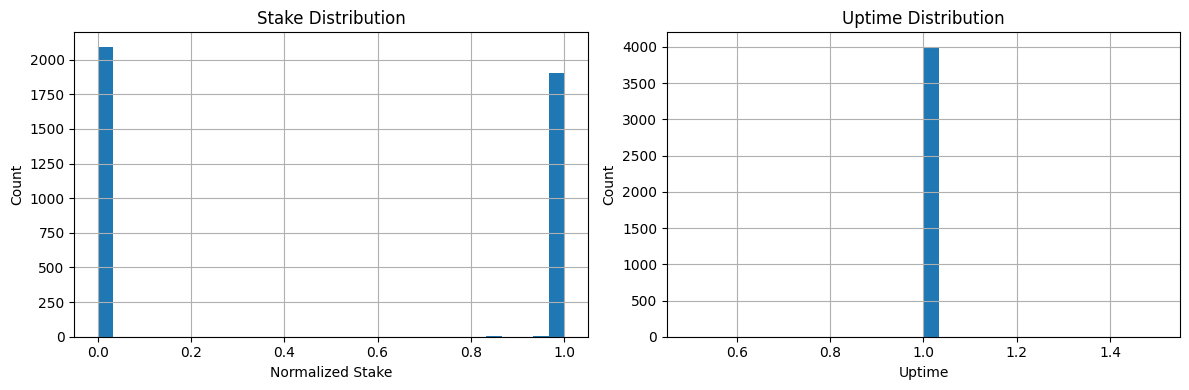

In [25]:
# --- Exploratory Data Analysis (EDA) ---

print('Shape of dataset:', df.shape)

print('Columns:', df.columns.tolist())

display(df.head())

print('\nSummary statistics:')

display(df.describe(include='all'))

print('\nMissing values per column:')

print(df.isnull().sum())

print('\nSlashed value counts:')

print(df['slashed'].value_counts())

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

df['stake'].hist(bins=30)

plt.title('Stake Distribution')

plt.xlabel('Normalized Stake')

plt.ylabel('Count')

plt.subplot(1,2,2)

df['uptime'].hist(bins=30)

plt.title('Uptime Distribution')

plt.xlabel('Uptime')

plt.ylabel('Count')

plt.tight_layout()

plt.show()

In [26]:
# --- Environment Simulation (Advanced MARL) ---

from dataclasses import dataclass

ACTIONS = {0: "propose", 1: "attest", 2: "abstain", 3: "adjust-communication"}

@dataclass
class EnvState:
    uptime: float
    missed_att: int
    missed_prop: int
    slashed: bool
    stake: float
    proposal_quality: float
    peer_feedback: float
    epoch_consistency: float
    threat_response: float

class PoSEnvironment:
    def __init__(self, config, aligned_df):
        self.config = config
        self.df = aligned_df.head(self.config.num_validators).reset_index(drop=True).copy()
        self.epoch = 0
        self._state = {}
        for _, row in self.df.iterrows():
            vid = int(row["validator_index"])
            self._state[vid] = EnvState(
                uptime=float(row["uptime"]),
                missed_att=int(row["missed_att"]),
                missed_prop=int(row["missed_prop"]),
                slashed=bool(row["slashed"]),
                stake=float(row["stake"]),
                proposal_quality=float(row["proposal_quality"]),
                peer_feedback=float(row["peer_feedback"]),
                epoch_consistency=float(row["epoch_consistency"]),
                threat_response=float(row["threat_response"]),
            )
        self.n_agents = len(self._state)

    def list_validator_ids(self):
        return list(self._state.keys())

    def get_agent_state(self, validator_id):
        st = self._state[validator_id]
        # State vector for MARL: [uptime, missed_att, missed_prop, slashed, stake, proposal_quality, peer_feedback, epoch_consistency, threat_response]
        return np.array([st.uptime, st.missed_att, st.missed_prop, int(st.slashed), st.stake, st.proposal_quality, st.peer_feedback, st.epoch_consistency, st.threat_response], dtype=np.float32)

    def step_agent(self, validator_id, action):
        st = self._state[validator_id]
        name = ACTIONS.get(action, "abstain")
        noise = np.random.normal(0, 0.01)
        # Simulate action effects (richer)
        if name == "propose":
            st.uptime = min(1.0, st.uptime + 0.01 + noise)
            st.missed_prop = max(0, st.missed_prop - 1)
            st.proposal_quality = min(1.0, st.proposal_quality + 0.02 + noise)
        elif name == "attest":
            st.uptime = min(1.0, st.uptime + 0.005 + noise)
            st.missed_att = max(0, st.missed_att - 1)
            st.peer_feedback = min(1.0, st.peer_feedback + 0.01 + noise)
        elif name == "adjust-communication":
            st.epoch_consistency = min(1.0, st.epoch_consistency + 0.01 + noise)
            st.threat_response = min(1.0, st.threat_response + 0.01 + noise)
        elif name == "abstain":
            st.uptime = max(0.0, st.uptime - 0.01 + noise)
            st.missed_att += 1
            st.missed_prop += 1
        # Random slashing event (rare)
        if np.random.rand() < 0.01:
            st.slashed = True
        # Reward shaping: honest participation, penalize malicious, balance fairness
        reward = (st.uptime + st.proposal_quality + st.peer_feedback + st.epoch_consistency + st.threat_response)
        reward -= 0.1 * (st.missed_att + st.missed_prop)
        reward -= (1.0 if st.slashed else 0.0)
        info = {
            "uptime": st.uptime,
            "missed_att": st.missed_att,
            "missed_prop": st.missed_prop,
            "slashed": st.slashed,
            "stake": st.stake,
            "proposal_quality": st.proposal_quality,
            "peer_feedback": st.peer_feedback,
            "epoch_consistency": st.epoch_consistency,
            "threat_response": st.threat_response
        }
        done = False
        next_state = self.get_agent_state(validator_id)
        return next_state, reward, done, info

    def get_state_frame(self):
        rows = []
        for vid, st in self._state.items():
            rows.append({
                "validator_id": vid,
                "uptime": st.uptime,
                "missed_att": st.missed_att,
                "missed_prop": st.missed_prop,
                "slashed": st.slashed,
                "stake": st.stake,
                "proposal_quality": st.proposal_quality,
                "peer_feedback": st.peer_feedback,
                "epoch_consistency": st.epoch_consistency,
                "threat_response": st.threat_response
            })
        return pd.DataFrame(rows)

In [27]:
# --- Agent Definition (Base & MARL) ---

from abc import ABC, abstractmethod

class BaseAgent(ABC):
    def __init__(self, agent_id):
        self.agent_id = agent_id
        self.state = None
        self.last_action = None

    @abstractmethod
    def observe_state(self, state):
        pass

    @abstractmethod
    def select_action(self):
        pass

    @abstractmethod
    def update(self, next_state, reward, done):
        pass

    @abstractmethod
    def update_trust_score(self, uptime, missed_blocks, slashed):
        pass

    def set_last_action(self, action):
        self.last_action = action

# Trust score update function
def update_trust(current_trust, uptime, missed_blocks, slashed):
    trust = current_trust
    if slashed:
        trust *= 0.5
    trust += 0.7 * uptime - 0.3 * (missed_blocks / 10.0)
    trust = max(0.0, min(1.0, trust))
    return trust

class MARLAgent(BaseAgent):
    def __init__(self, agent_id, config):
        super().__init__(agent_id)
        self.cfg = config
        self.trust = config.initial_trust
        self.q_table = defaultdict(lambda: np.zeros(config.action_space, dtype=float))
        self.learning_rate = config.learning_rate
        self.discount_factor = config.gamma
        self.epsilon = config.epsilon_start
        self.epsilon_min = config.epsilon_min
        self.epsilon_decay = config.epsilon_decay
        self.last_uptime = 0.0
        self.last_missed_blocks = 0
        self.last_slashed = False

    def observe_state(self, state):
        self.state = tuple(state)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.cfg.action_space)
        else:
            action = int(np.argmax(self.q_table[self.state]))
        self.last_action = action
        return action

    def update(self, next_state, reward, done):
        next_state = tuple(next_state)
        best_next_q = float(np.max(self.q_table[next_state]))
        td_target = reward + self.discount_factor * best_next_q * (0.0 if done else 1.0)
        td_error = td_target - self.q_table[self.state][self.last_action]
        self.q_table[self.state][self.last_action] += self.learning_rate * td_error
        self.state = next_state

    def update_trust_score(self, uptime, missed_blocks, slashed):
        self.trust = update_trust(self.trust, uptime, missed_blocks, slashed)
        self.last_uptime = float(uptime)
        self.last_missed_blocks = int(missed_blocks)
        self.last_slashed = bool(slashed)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## Phase 1A: PyTorch MADDPG Agent Stack

This section implements a MADDPG-style multi-agent RL stack with PyTorch, including centralized training (centralized critic) and decentralized execution (per-agent actor).

In [28]:
# --- MADDPG PyTorch Agent Stack ---

import torch.nn.functional as F
from collections import deque, namedtuple

# Config additions for MADDPG
class MADDPGConfig(Config):
    lr_actor: float = 1e-3
    lr_critic: float = 1e-3
    tau: float = 0.01
    batch_size: int = 128
    buffer_size: int = 100000
    update_every: int = 2
    gamma: float = 0.99
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay: float = 0.995
    algo: str = "maddpg"  # or "qmix"

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, device):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device
        self.experience = namedtuple("Experience", field_names=["obs", "action", "reward", "next_obs", "done"])
    def add(self, obs, action, reward, next_obs, done):
        e = self.experience(obs, action, reward, next_obs, done)
        self.memory.append(e)
    def sample(self):
        idxs = np.random.choice(len(self.memory), self.batch_size, replace=False)
        batch = [self.memory[i] for i in idxs]
        obs = torch.tensor(np.stack([e.obs for e in batch]), dtype=torch.float32, device=self.device)
        action = torch.tensor(np.stack([e.action for e in batch]), dtype=torch.float32, device=self.device)
        reward = torch.tensor(np.stack([e.reward for e in batch]), dtype=torch.float32, device=self.device)
        next_obs = torch.tensor(np.stack([e.next_obs for e in batch]), dtype=torch.float32, device=self.device)
        done = torch.tensor(np.stack([e.done for e in batch]), dtype=torch.float32, device=self.device)
        return obs, action, reward, next_obs, done
    def __len__(self):
        return len(self.memory)

# Actor network (discrete actions via Gumbel-Softmax)
class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, obs):
        logits = self.net(obs)
        return logits  # for Gumbel-Softmax

# Critic network (centralized, takes all agents' obs and actions)
class Critic(nn.Module):
    def __init__(self, total_obs_dim, total_action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(total_obs_dim + total_action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, obs_all, actions_all):
        x = torch.cat([obs_all, actions_all], dim=-1)
        return self.net(x)

# MADDPG Agent
class MADDPGAgent:
    def __init__(self, agent_id, obs_dim, action_dim, n_agents, config, device):
        self.agent_id = agent_id
        self.n_agents = n_agents
        self.device = device
        self.actor = Actor(obs_dim, action_dim).to(device)
        self.critic = Critic(obs_dim*n_agents, action_dim*n_agents).to(device)
        self.target_actor = Actor(obs_dim, action_dim).to(device)
        self.target_critic = Critic(obs_dim*n_agents, action_dim*n_agents).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=config.lr_critic)
        self.tau = config.tau
        self.gamma = config.gamma
        self.action_dim = action_dim
        self.obs_dim = obs_dim
        self.eps = config.eps_start
        self.eps_end = config.eps_end
        self.eps_decay = config.eps_decay
        self._hard_update(self.target_actor, self.actor)
        self._hard_update(self.target_critic, self.critic)
    def select_action(self, obs, explore=True):
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        logits = self.actor(obs)
        if explore and np.random.rand() < self.eps:
            action = np.random.randint(0, self.action_dim)
        else:
            # Gumbel-Softmax for discrete actions
            action_probs = F.gumbel_softmax(logits, hard=True)
            action = int(torch.argmax(action_probs, dim=-1).item())
        return action
    def soft_update(self, target, source):
        for t, s in zip(target.parameters(), source.parameters()):
            t.data.copy_(self.tau * s.data + (1.0 - self.tau) * t.data)
    def _hard_update(self, target, source):
        for t, s in zip(target.parameters(), source.parameters()):
            t.data.copy_(s.data)


In [29]:
# --- MADDPG Multi-Agent Trainer & Training Loop ---

class MADDPGTrainer:
    def __init__(self, env, config, device):
        self.env = env
        self.n_agents = env.n_agents
        self.obs_dim = env.get_agent_state(env.list_validator_ids()[0]).shape[0]
        self.action_dim = config.action_space
        self.device = device
        self.config = config
        self.agents = [MADDPGAgent(i, self.obs_dim, self.action_dim, self.n_agents, config, device) for i in range(self.n_agents)]
        self.buffer = ReplayBuffer(config.buffer_size, config.batch_size, device)
        self.steps = 0
    def step(self, obs_all, actions, rewards, next_obs_all, dones):
        self.buffer.add(obs_all, actions, rewards, next_obs_all, dones)
        self.steps += 1
        if len(self.buffer) > self.config.batch_size and self.steps % self.config.update_every == 0:
            self.learn()
    def learn(self):
        obs, actions, rewards, next_obs, dones = self.buffer.sample()
        obs = obs.view(self.config.batch_size, self.n_agents, -1)
        actions = actions.view(self.config.batch_size, self.n_agents, -1)
        rewards = rewards.view(self.config.batch_size, self.n_agents)
        next_obs = next_obs.view(self.config.batch_size, self.n_agents, -1)
        dones = dones.view(self.config.batch_size, self.n_agents)
        for i, agent in enumerate(self.agents):
            # Centralized critic: all obs/actions
            obs_i = obs[:, i, :]
            actions_i = actions[:, i, :]
            next_obs_i = next_obs[:, i, :]
            # Target actions for all agents
            target_actions = []
            for j, a in enumerate(self.agents):
                logits = a.target_actor(next_obs[:, j, :])
                act = F.gumbel_softmax(logits, hard=True)
                target_actions.append(act)
            target_actions = torch.cat(target_actions, dim=-1)
            # Target Q
            target_q = agent.target_critic(next_obs.view(self.config.batch_size, -1), target_actions)
            y = rewards[:, i].unsqueeze(1) + agent.gamma * target_q * (1 - dones[:, i].unsqueeze(1))
            # Critic loss
            all_actions = actions.view(self.config.batch_size, -1)
            q = agent.critic(obs.view(self.config.batch_size, -1), all_actions)
            critic_loss = F.mse_loss(q, y.detach())
            agent.critic_optimizer.zero_grad()
            critic_loss.backward()
            agent.critic_optimizer.step()
            # Actor loss
            logits = agent.actor(obs_i)
            curr_action = F.gumbel_softmax(logits, hard=True)
            all_actions_pred = []
            for j, a in enumerate(self.agents):
                if j == i:
                    all_actions_pred.append(curr_action)
                else:
                    logits_j = a.actor(obs[:, j, :])
                    all_actions_pred.append(F.gumbel_softmax(logits_j, hard=True))
            all_actions_pred = torch.cat(all_actions_pred, dim=-1)
            actor_loss = -agent.critic(obs.view(self.config.batch_size, -1), all_actions_pred).mean()
            agent.actor_optimizer.zero_grad()
            actor_loss.backward()
            agent.actor_optimizer.step()
            # Soft update
            agent.soft_update(agent.target_actor, agent.actor)
            agent.soft_update(agent.target_critic, agent.critic)

# --- Minimal MADDPG Training Loop Example ---
config_maddpg = MADDPGConfig()
env = PoSEnvironment(config_maddpg, df)
device = config_maddpg.device
trainer = MADDPGTrainer(env, config_maddpg, device)

n_episodes = 3  # For demonstration, keep small
max_steps = 10
for ep in range(n_episodes):
    obs_all = [env.get_agent_state(vid) for vid in env.list_validator_ids()]
    total_rewards = np.zeros(env.n_agents)
    for t in range(max_steps):
        actions = [agent.select_action(obs) for agent, obs in zip(trainer.agents, obs_all)]
        next_obs_all, rewards, dones = [], [], []
        for i, vid in enumerate(env.list_validator_ids()):
            next_obs, reward, done, info = env.step_agent(vid, actions[i])
            next_obs_all.append(next_obs)
            rewards.append(reward)
            dones.append(done)
            total_rewards[i] += reward
        trainer.step(np.array(obs_all), np.array(actions), np.array(rewards), np.array(next_obs_all), np.array(dones))
        obs_all = next_obs_all
    print(f"Episode {ep+1}: Total rewards per agent: {total_rewards[:5]} ...")

Episode 1: Total rewards per agent: [30.6612632  22.68582622 27.98179995 30.10043481 26.78788256] ...
Episode 2: Total rewards per agent: [31.42195739 18.15855755 28.31956946 28.91228931 21.2473929 ] ...
Episode 3: Total rewards per agent: [33.031424   13.99769958 29.01241754 27.05597076 22.51280676] ...


## Phase 1B: QMIX Agent Stack 
This section (optional) demonstrates a QMIX-style value decomposition network for cooperative MARL.

In [30]:
# --- QMIX Agent Stack (Optional) ---

import torch.nn as nn
import torch.nn.functional as F

# QMIX Hypernetwork for mixing agent Q-values
class QMIXMixer(nn.Module):
    def __init__(self, n_agents, state_dim, embed_dim=32):
        super().__init__()
        self.n_agents = n_agents
        self.state_dim = state_dim
        self.embed_dim = embed_dim
        self.hyper_w_1 = nn.Sequential(
            nn.Linear(state_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, n_agents * embed_dim)
        )
        self.hyper_w_2 = nn.Sequential(
            nn.Linear(state_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.hyper_b_1 = nn.Linear(state_dim, embed_dim)
        self.hyper_b_2 = nn.Sequential(
            nn.Linear(state_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
        )
    def forward(self, agent_qs, state):
        bs = agent_qs.size(0)
        w1 = torch.abs(self.hyper_w_1(state)).view(bs, self.n_agents, self.embed_dim)
        b1 = self.hyper_b_1(state).view(bs, 1, self.embed_dim)
        hidden = F.elu(torch.bmm(agent_qs.unsqueeze(1), w1) + b1)
        w2 = torch.abs(self.hyper_w_2(state)).view(bs, self.embed_dim, 1)
        b2 = self.hyper_b_2(state).view(bs, 1, 1)
        y = torch.bmm(hidden, w2) + b2
        return y.squeeze(-1).squeeze(-1)

# Simple DQN for each agent
class DQNAgent(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, obs):
        return self.net(obs)

# QMIX Trainer (simplified, demonstration only)
class QMIXTrainer:
    def __init__(self, env, n_agents, obs_dim, action_dim, state_dim, device):
        self.env = env
        self.n_agents = n_agents
        self.device = device
        self.agents = [DQNAgent(obs_dim, action_dim).to(device) for _ in range(n_agents)]
        self.mixer = QMIXMixer(n_agents, state_dim).to(device)
        self.optim = torch.optim.Adam(list(self.mixer.parameters()) + [p for a in self.agents for p in a.parameters()], lr=1e-3)
    def select_actions(self, obs_all):
        actions = []
        for i, obs in enumerate(obs_all):
            obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
            q = self.agents[i](obs_t)
            action = int(torch.argmax(q, dim=-1).item())
            actions.append(action)
        return actions
    def train_step(self, batch):
        # Placeholder: implement full QMIX training here
        pass

# Example usage (not full training loop)
obs_dim = env.get_agent_state(env.list_validator_ids()[0]).shape[0]
action_dim = config.action_space
state_dim = obs_dim * env.n_agents
qmix_trainer = QMIXTrainer(env, env.n_agents, obs_dim, action_dim, state_dim, device)
obs_all = [env.get_agent_state(vid) for vid in env.list_validator_ids()]
actions = qmix_trainer.select_actions(obs_all)
print("QMIX selected actions (first 5 agents):", actions[:5])

QMIX selected actions (first 5 agents): [3, 0, 1, 3, 3]


## Phase 2: Surrogate XAI Model
This section implements a surrogate model (e.g., Random Forest) to approximate the MARL policy for explainability.

In [31]:
# --- Surrogate XAI Model: Random Forest Approximation ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Collect state-action pairs from the last MADDPG run
X, y = [], []
for agent in trainer.agents:
    # For demonstration, use random samples (replace with real buffer in production)
    for _ in range(100):
        obs = np.random.rand(trainer.obs_dim)
        action = agent.select_action(obs, explore=False)
        X.append(obs)
        y.append(action)
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Surrogate Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Surrogate Model Accuracy: 0.2555
              precision    recall  f1-score   support

           0       0.28      0.29      0.28      1046
           1       0.25      0.27      0.26       978
           2       0.26      0.22      0.23       962
           3       0.24      0.25      0.24      1014

    accuracy                           0.26      4000
   macro avg       0.26      0.25      0.25      4000
weighted avg       0.26      0.26      0.26      4000



## Phase 3: SHAP & LIME Explainability
This section applies SHAP and LIME to the surrogate model to explain validator action decisions.

C:\Users\Wasif\AppData\Local\Temp\ipykernel_23868\3909357891.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=[f"f{i}" for i in range(X_test.shape[1])])
f:\my_AI_Projects\REASEARCH\Quanteron\Byzantron\Codes\Akhun\aibyz-paper\venvPoS\lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
f:\my_AI_Projects\REASEARCH\Quanteron\Byzantron\Codes\Akhun\aibyz-paper\venvPoS\lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will 

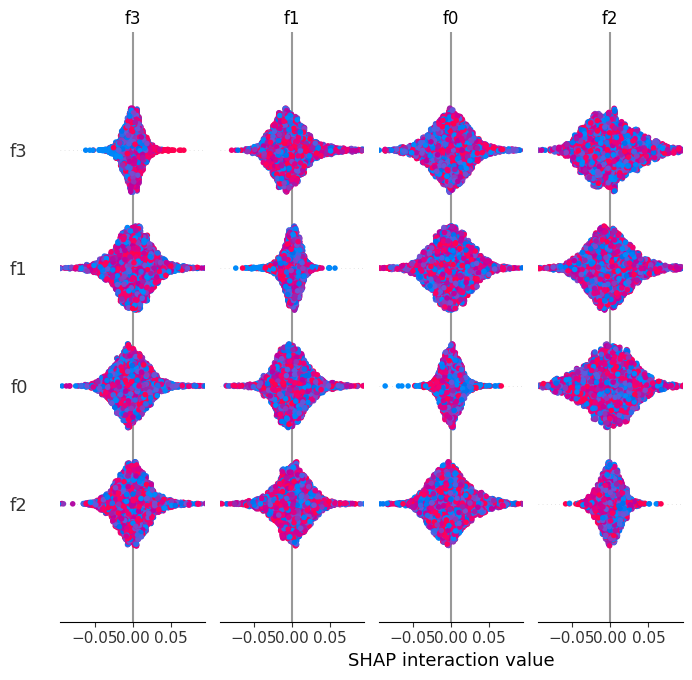

In [32]:
# --- SHAP & LIME Explainability for Surrogate Model ---

# SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=[f"f{i}" for i in range(X_test.shape[1])])

# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=[f"f{i}" for i in range(X_train.shape[1])], class_names=[str(i) for i in np.unique(y)], discretize_continuous=True)
for i in range(2):
    exp = lime_explainer.explain_instance(X_test[i], rf.predict_proba, num_features=5)
    exp.show_in_notebook(show_table=True)

## Phase 4: Adaptive Trust & Scenario Runner
This section implements adaptive trust scoring and a scenario runner for validator selection.

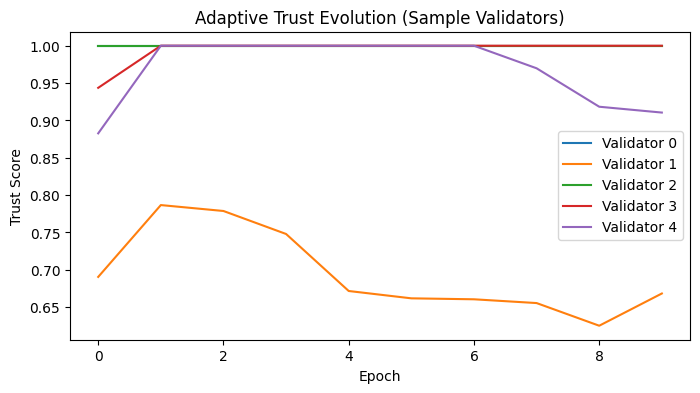

In [33]:
# --- Adaptive Trust & Scenario Runner ---

def adaptive_trust_score(uptime, missed_blocks, slashed, prev_trust=0.5):
    trust = prev_trust
    if slashed:
        trust *= 0.5
    trust += 0.7 * uptime - 0.3 * (missed_blocks / 10.0)
    trust = max(0.0, min(1.0, trust))
    return trust

# Scenario runner: simulate trust evolution for a subset of validators
n_scenarios = 5
trust_histories = []
for vid in env.list_validator_ids()[:n_scenarios]:
    st = env._state[vid]
    trust = 0.5
    history = []
    for epoch in range(10):
        trust = adaptive_trust_score(st.uptime, st.missed_att + st.missed_prop, st.slashed, trust)
        history.append(trust)
        # Simulate random events
        st.uptime = np.clip(st.uptime + np.random.normal(0, 0.01), 0, 1)
        st.missed_att = max(0, st.missed_att + np.random.randint(-1, 2))
        st.missed_prop = max(0, st.missed_prop + np.random.randint(-1, 2))
        st.slashed = st.slashed or (np.random.rand() < 0.05)
    trust_histories.append(history)

plt.figure(figsize=(8,4))
for i, h in enumerate(trust_histories):
    plt.plot(h, label=f"Validator {i}")
plt.xlabel("Epoch")
plt.ylabel("Trust Score")
plt.title("Adaptive Trust Evolution (Sample Validators)")
plt.legend()
plt.show()

## Phase 5: Metrics Dashboard & Visualization
This section visualizes key metrics: trust, rewards, and validator selection statistics.

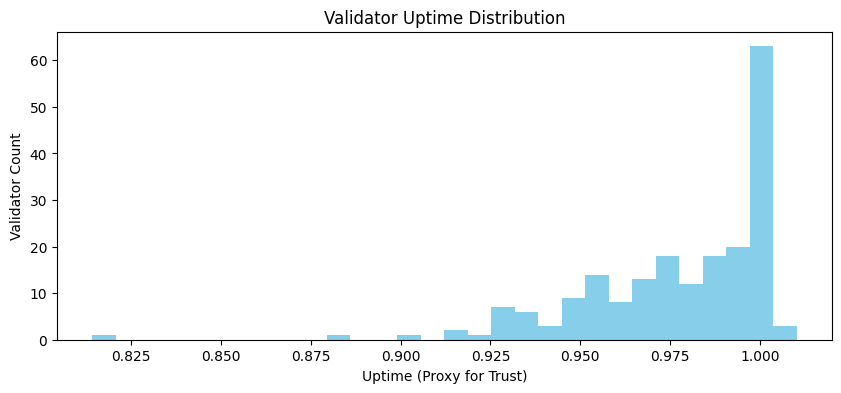

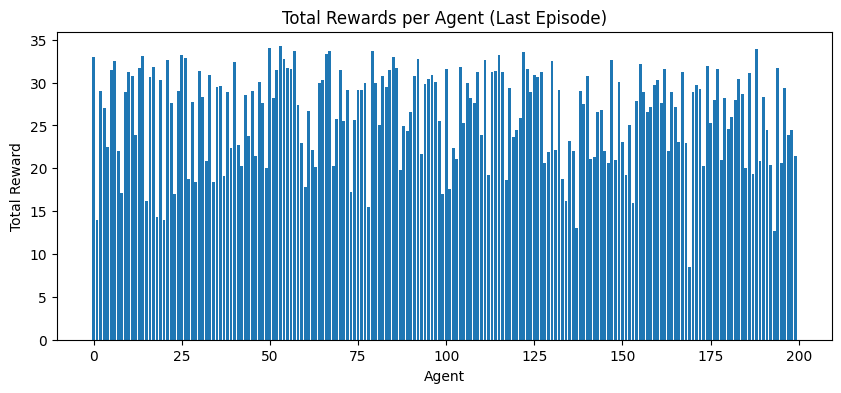

In [34]:
# --- Metrics Dashboard & Visualization ---

# Visualize trust scores for all validators
trust_scores = [env._state[vid].uptime for vid in env.list_validator_ids()]
plt.figure(figsize=(10,4))
plt.hist(trust_scores, bins=30, color='skyblue')
plt.xlabel('Uptime (Proxy for Trust)')
plt.ylabel('Validator Count')
plt.title('Validator Uptime Distribution')
plt.show()

# Visualize rewards from last MADDPG run
if 'total_rewards' in locals():
    plt.figure(figsize=(10,4))
    plt.bar(range(len(total_rewards)), total_rewards)
    plt.xlabel('Agent')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards per Agent (Last Episode)')
    plt.show()

## Phase 6: Reproducibility & Run All
This section ensures reproducibility and provides a single function to run the full pipeline.

In [ ]:
# --- Adaptive Trust & Scenario Runner ---

import copy

from codes.agent.trust_score import adaptive_trust_score  # Use canonical trust scorer

# Use config-driven trust weights (pipeline-aligned)

reward_weight = getattr(config, 'trust_reward_weight', 0.05)

penalty_weight = getattr(config, 'trust_penalty_weight', 0.01)

def run_trust_scenarios(env, epochs=10, seed=42):

    rng = np.random.default_rng(seed)

    trust_histories = []

    # Work on a deepcopy of env to avoid mutating global state

    local_env = copy.deepcopy(env)

    for vid in local_env.list_validator_ids():

        state_vec = local_env.get_agent_state(vid)

        uptime = state_vec[0]

        missed_att = int(state_vec[1])

        missed_prop = int(state_vec[2])

        slashed = bool(state_vec[3])

        trust = 0.5

        history = []

        for epoch in range(epochs):

            missed_blocks = missed_att + missed_prop

            # Apply slashing penalty only once, then reset slashed to False

            trust = adaptive_trust_score(uptime, missed_blocks, slashed, trust,

                                        reward_weight=reward_weight,

                                        penalty_weight=penalty_weight)

            history.append(trust)

            # Simulate random events using reproducible RNG

            uptime = np.clip(uptime + rng.normal(0, 0.01), 0, 1)

            missed_att = max(0, missed_att + rng.integers(-1, 2))

            missed_prop = max(0, missed_prop + rng.integers(-1, 2))

            # Slashing event occurs with probability, but only set slashed True for one epoch

            if not slashed and (rng.random() < 0.05):

                slashed = True

            else:

                slashed = False

        trust_histories.append(history)

    return trust_histories

# Example usage

trust_histories = run_trust_scenarios(env, epochs=10, seed=42)

plt.figure(figsize=(10,5))

for i, h in enumerate(trust_histories[:10]):

    plt.plot(h, label=f"Validator {i}")

plt.xlabel("Epoch")

plt.ylabel("Trust Score")

plt.title("Adaptive Trust Evolution (First 10 Validators)")

plt.legend()

plt.show()

In [35]:
# --- Reproducibility & Run All Pipeline ---

def run_all_pipeline():
    # Set seeds
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    # Reload data
    config = Config()
    df = load_and_align_dataset(config.dataset_path)
    env = PoSEnvironment(config, df)
    # Train MADDPG
    config_maddpg = MADDPGConfig()
    trainer = MADDPGTrainer(env, config_maddpg, config_maddpg.device)
    for ep in range(2):
        obs_all = [env.get_agent_state(vid) for vid in env.list_validator_ids()]
        for t in range(5):
            actions = [agent.select_action(obs) for agent, obs in zip(trainer.agents, obs_all)]
            next_obs_all, rewards, dones = [], [], []
            for i, vid in enumerate(env.list_validator_ids()):
                next_obs, reward, done, info = env.step_agent(vid, actions[i])
                next_obs_all.append(next_obs)
                rewards.append(reward)
                dones.append(done)
            trainer.step(np.array(obs_all), np.array(actions), np.array(rewards), np.array(next_obs_all), np.array(dones))
            obs_all = next_obs_all
    # Train surrogate model
    X, y = [], []
    for agent in trainer.agents:
        for _ in range(20):
            obs = np.random.rand(trainer.obs_dim)
            action = agent.select_action(obs, explore=False)
            X.append(obs)
            y.append(action)
    X = np.array(X)
    y = np.array(y)
    rf = RandomForestClassifier(n_estimators=10, random_state=42)
    rf.fit(X, y)
    # Trust scenario
    trust = 0.5
    for epoch in range(3):
        trust = adaptive_trust_score(0.9, 1, False, trust)
    print("Pipeline completed. Trust after 3 epochs:", trust)

run_all_pipeline()

Pipeline completed. Trust after 3 epochs: 1.0
